In [38]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import warnings
%matplotlib inline
from sklearn import tree
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix#for visualizing tree
from sklearn import svm
import datetime
warnings.filterwarnings("ignore")

**Loading Data**

In [39]:
data = pd.read_csv("C:/Users/rakray/Documents/Deloitte_Training/Code/deloitte-training-project-1/datasets/application_data.csv")
df_application_data = pd.DataFrame(data)
data = pd.read_csv("C:/Users/rakray/Documents/Deloitte_Training/Code/deloitte-training-project-1/datasets/previous_application.csv")
df_previous_application = pd.DataFrame(data)

In [40]:
df_application_data["ad_target_ct"].value_counts()

0    282686
1     24825
Name: ad_target_ct, dtype: int64

**Missing value removal**

In [41]:
acceptable_non_NAN_values_fraction = 0.5
df_application_data_2 = df_application_data.dropna(axis='columns', how="any", thresh=(1-acceptable_non_NAN_values_fraction)*len(df_application_data.index))
df_previous_application_2 = df_previous_application.dropna(axis='columns', how="any", thresh=(1-acceptable_non_NAN_values_fraction)*len(df_previous_application.index))

In [42]:
df_application_data_2["ad_target_ct"].value_counts()

0    282686
1     24825
Name: ad_target_ct, dtype: int64

**NAN value replacement**

In [43]:
def NAN_value_replacement(dataframe):
    for col in dataframe:
        if (dataframe[col].dtype == "int64" or dataframe[col].dtype == "float64"):
            dataframe[col] = dataframe[col].fillna(dataframe[col].median())
        elif (dataframe[col].dtype == "object"):
            dataframe[col] = dataframe[col].fillna(dataframe[col].mode().iloc[0])
    return dataframe

df_application_data_2 = NAN_value_replacement(df_application_data_2)
df_previous_application_2 = NAN_value_replacement(df_previous_application_2)

In [44]:
df_application_data_2["ad_target_ct"].value_counts()

0    282686
1     24825
Name: ad_target_ct, dtype: int64

**Boxplot**

In [45]:
def Boxplot(dataframe, column):
    plt.figure(figsize=(10,7))
    plt.title(column)
    plt.boxplot(dataframe[column])
    plt.show()

**Numerical Dataframe**

In [46]:
def numerical_df(df):
    numerical = df.select_dtypes(exclude='object')
    return numerical
# gettting numerical dfs
numerical_df_previous_application = numerical_df(df_previous_application_2)
numerical_df_application_data = numerical_df(df_application_data_2)

In [47]:
df_application_data_2["ad_target_ct"].value_counts()

0    282686
1     24825
Name: ad_target_ct, dtype: int64

**Removing outliers**

In [48]:
# Outlier removing function
def new_IQR(res_df, numerical_df):
#     res_df_new = res_df.copy()
    for i in list(numerical_df):
        sorted(i)
        iqr1 = res_df[i].quantile(0.25)
        iqr3 = res_df[i].quantile(0.75)
        iqr = iqr3-iqr1
        lower_limit = iqr1 - 1.5*iqr
        upper_limit = iqr3 + 1.5*iqr
        temp_data = res_df[(res_df[i] > lower_limit) & (res_df[i] <upper_limit)]
#         print(temp_data)
#         print((res_df[i] > lower_limit) & (res_df[i] <upper_limit))
        
        if temp_data[i].value_counts().shape[0] > 10:
            res_df = res_df[(res_df[i] > lower_limit) & (res_df[i] <upper_limit)]
#             print(res_df)
    return res_df

In [49]:
# Removing outliers
df_previous_application_2 = new_IQR(df_previous_application_2, numerical_df_previous_application)
df_application_data_2 = new_IQR(df_application_data_2, numerical_df_application_data)

In [50]:
df_application_data_2["ad_target_ct"].value_counts()

0    96712
1    11149
Name: ad_target_ct, dtype: int64

**Categorical data**

In [51]:
# categorical
df_previous_application_2["ad_MONTHS_decision_ct"] = abs(df_previous_application_2["ad_days_decision_ct"])/30
bins = [0,1,2,3,4,5,6,7,8,9,np.inf]
slots = ["0-1","1-2","2-3","3-4","4-5","5-6","6-7","7-8","8-9","Above 9"]
df_previous_application_2["ad_MONTHS_decision_ct"] = pd.cut(df_previous_application_2["ad_MONTHS_decision_ct"], bins=bins, labels=slots)

df_application_data_2["ad_YEARS_birth_ct"] = abs(df_application_data_2["ad_days_birth_ct"])/365
bins = [0,10,20,30,40,50,60,70,80,90,np.inf]
slots = ["0-10","11-20","21-30","31-40","41-50","51-60","61-70","71-80","81-90","Above 90"]
df_application_data_2["ad_YEARS_birth_ct"] = pd.cut(df_application_data_2["ad_YEARS_birth_ct"], bins=bins, labels=slots)

In [52]:
df_application_data_2["ad_target_ct"].value_counts()

0    96712
1    11149
Name: ad_target_ct, dtype: int64

**Encoding**

In [53]:
# Encoding
def encoder(dataframe):
    label_encoder = preprocessing.LabelEncoder()
    for (columnName, columnData) in dataframe.iteritems():
        if columnData.dtypes == "object" or columnData.dtype.name == "category":
            # print(dataframe[columnName].dtypes)
            dataframe[columnName] = label_encoder.fit_transform(dataframe[columnName])
    return dataframe

# df_previous_application_2 = encoder(df_previous_application_2)
# df_application_data_2 = encoder(df_application_data_2)

In [54]:
df_application_data_2["ad_target_ct"].value_counts()

0    96712
1    11149
Name: ad_target_ct, dtype: int64

**Feature Selection**

In [55]:
# Feature Selection - Correlation Coefficient
def corr_co(name, dataframe, thresh, plot_visibility):
    corr_matrix = dataframe.corr()
    if (plot_visibility):
        sns.heatmap(corr_matrix,annot=True,cmap=plt.cm.CMRmap_r)
        plt.show()

    coll_corr = []
    threshold = thresh

    flag = 0

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                if colname not in coll_corr and flag > 0:
                    coll_corr.append(colname)
                    # print(colname)
                flag+=1
    # print ("\n\n")
    return coll_corr

# calling correlation coefficient function
corr_matrix_previous_application = corr_co("previous_application.csv", df_previous_application_2, 0.85, False)
corr_matrix_application_data = corr_co("current_application", df_application_data_2, 0.85, False)

In [56]:
# drop the columns obtained from coefficient function
df_previous_application_2_dropped = df_previous_application_2.drop(labels=corr_matrix_previous_application, inplace=False, axis=1)
df_application_data_2_dropped = df_application_data_2.drop(labels=corr_matrix_application_data, inplace=False, axis=1)

In [57]:
df_application_data_2["ad_target_ct"].value_counts()

0    96712
1    11149
Name: ad_target_ct, dtype: int64

In [58]:
df_application_data_2_dropped["ad_target_ct"].value_counts()

0    96712
1    11149
Name: ad_target_ct, dtype: int64

**Merge**

In [59]:
# merge
merged_dataframe = pd.merge(df_application_data_2, df_previous_application_2, how='inner', on='ad_sk_id_curr_ct')
today = datetime.datetime.today().strftime('%d-%m-%Y')
merged_dataframe.to_csv(f'raktim-cleaned-data-{today}.csv', index=False)

**Creating table schema for redshift from dataframe**

In [60]:
print("create table sample (")
output = ""
for i in merged_dataframe.columns:
    datatype = merged_dataframe[i].dtypes
    if datatype == 'int64':
        output = 'int'
    elif datatype == 'float64':
        output = 'float'
    else:
        output = 'varchar(100)'
    print(i+" "+output+",")
print(");")

create table sample (
ad_sk_id_curr_ct int,
ad_target_ct int,
ad_name_contract_type_ct_x varchar(100),
ad_code_gender_ct varchar(100),
ad_flag_own_car_ct varchar(100),
ad_flag_own_realty_ct varchar(100),
ad_cnt_children_ct int,
ad_amt_income_total_ct float,
ad_amt_credit_ct_x float,
ad_amt_annuity_ct_x float,
ad_amt_goods_price_ct_x float,
ad_name_type_suite_ct_x varchar(100),
ad_name_income_type_ct varchar(100),
ad_name_education_type_ct varchar(100),
ad_name_family_status_ct varchar(100),
ad_name_housing_type_ct varchar(100),
ad_region_population_relative_ct float,
ad_days_birth_ct int,
ad_days_employed_ct int,
ad_days_registration_ct float,
ad_days_id_publish_ct int,
ad_flag_mobil_ct int,
ad_flag_emp_phone_ct int,
ad_flag_work_phone_ct int,
ad_flag_cont_mobile_ct int,
ad_flag_phone_ct int,
ad_flag_email_ct int,
ad_occupation_type_ct varchar(100),
ad_cnt_fam_members_ct float,
ad_region_rating_client_ct int,
ad_region_rating_client_w_city_ct int,
ad_weekday_appr_process_start_ct_x var

In [61]:
# merged_dataframe.dtypes
# merged_dataframe.info(verbose=True)

**Univariate**

In [80]:
# sample
def data_type(dataset,col):
    if dataset[col].dtype == np.int64 or dataset[col].dtype == np.float64 or dataset[col].dtype == np.int32:
        return "numerical"
    if dataset[col].dtype == "object":
        return "categorical"

def univariate(dataset,col,target_col,ylog=False,x_label_angle=False,h_layout=True):
    if data_type(dataset,col) == "numerical":
        sns.distplot(dataset[col],hist=False)
        
        
    elif data_type(dataset,col) == "categorical":
        val_count = dataset[col].value_counts()
        df1 = pd.DataFrame({col: val_count.index,'count': val_count.values})
        
        
        target_1_percentage = dataset[[col, target_col]].groupby([col],as_index=False).mean()
        target_1_percentage[target_col] = target_1_percentage[target_col]*100
        target_1_percentage.sort_values(by=target_col,inplace = True)

# If the plot is not readable, use the log scale

        if(h_layout):
            fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,7))
        else:
            fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(25,35))
              
        
# 1. Subplot 1: Count plot of the column
        
        
        s = sns.countplot(ax=ax1, x=col, data=dataset, hue=target_col)
        s.set_xticklabels(s.get_xticklabels(), rotation=45)
        ax1.set_title(col, fontsize = 20)
        ax1.legend(['Repayer','Defaulter'])
        ax1.set_xlabel(col,fontdict={'fontsize' : 15, 'fontweight' : 3})
        
        if(x_label_angle):
            s.set_xticklabels(s.get_xticklabels(),rotation=75)
        
# 2. Subplot 2: Percentage of defaulters within the column
        
        s = sns.barplot(ax=ax2, x = col, y=target_col, data=target_1_percentage)
        ax2.set_title("Defaulters % in "+col, fontsize = 20)    
        ax2.set_xlabel(col,fontdict={'fontsize' : 15, 'fontweight' : 3})
        ax2.set_ylabel(target_col,fontdict={'fontsize' : 15, 'fontweight' : 3})
        
        if(x_label_angle):
            s.set_xticklabels(s.get_xticklabels(),rotation=75)
            
            
# If the plot is not readable, use the log scale
                
        if ylog:
            ax1.set_yscale('log')
            ax1.set_ylabel("Count (log)",fontdict={'fontsize' : 15, 'fontweight' : 3})
        else:
            ax1.set_ylabel("Count",fontdict={'fontsize' : 15, 'fontweight' : 3})

        plt.xticks(rotation = 45)
        plt.show()

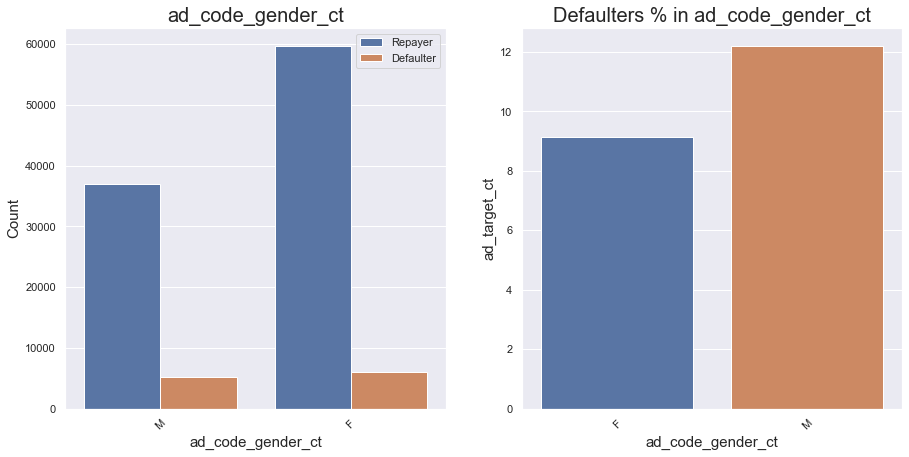

In [81]:
# Univariate call
univariate(df_application_data_2_dropped, "ad_code_gender_ct", "ad_target_ct")

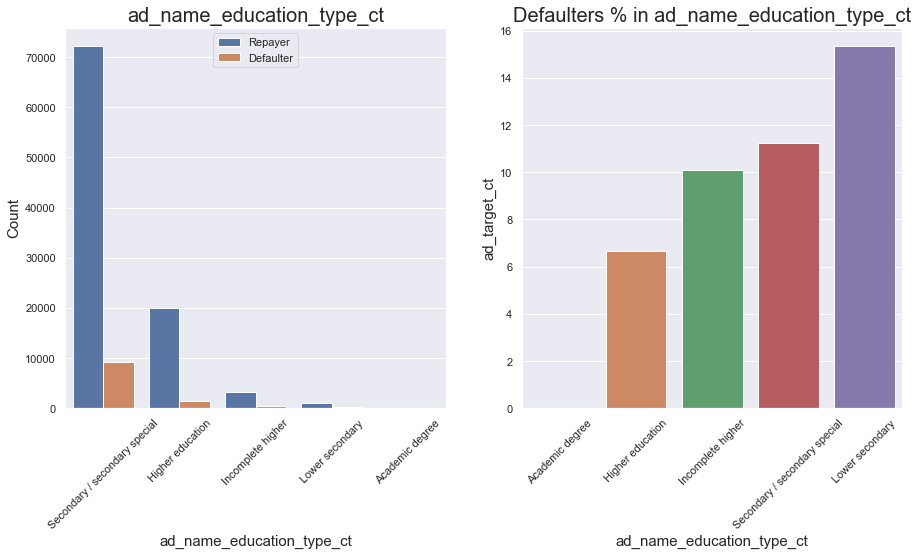

In [82]:
univariate(df_application_data_2_dropped, "ad_name_education_type_ct", "ad_target_ct")

**Insights**


Insight dataframe - 1: Education Type

    ad_sk_id_curr_ct  ad_target_ct      ad_name_education_type_ct
2             100004             0  Secondary / secondary special
3             100006             0  Secondary / secondary special
4             100007             0  Secondary / secondary special
5             100008             0  Secondary / secondary special
10            100014             0               Higher education


[Text(0, 0, 'Secondary / secondary special'),
 Text(1, 0, 'Higher education'),
 Text(2, 0, 'Incomplete higher'),
 Text(3, 0, 'Lower secondary'),
 Text(4, 0, 'Academic degree')]

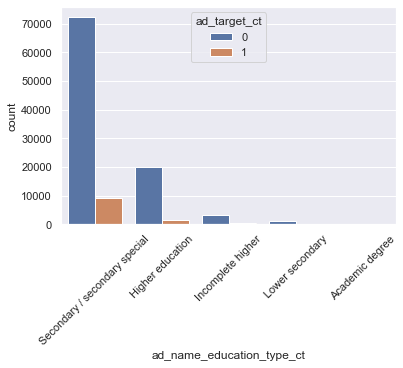

In [65]:
# Insight dataframe 1
insight_df_1 = df_application_data_2[["ad_sk_id_curr_ct", "ad_target_ct", "ad_name_education_type_ct"]]
print("\nInsight dataframe - 1: Education Type\n")
print(insight_df_1.head())
col = 'ad_name_education_type_ct'
target_col = 'ad_target_ct'
sns.set()
s = sns.countplot(insight_df_1[col],hue=insight_df_1[target_col])
s.set_xticklabels(s.get_xticklabels(), rotation=45)


Insight dataframe - 2: Housing Type

    ad_sk_id_curr_ct  ad_target_ct ad_name_housing_type_ct
2             100004             0       House / apartment
3             100006             0       House / apartment
4             100007             0       House / apartment
5             100008             0       House / apartment
10            100014             0       House / apartment


[Text(0, 0, 'House / apartment'),
 Text(1, 0, 'Rented apartment'),
 Text(2, 0, 'Municipal apartment'),
 Text(3, 0, 'With parents'),
 Text(4, 0, 'Office apartment'),
 Text(5, 0, 'Co-op apartment')]

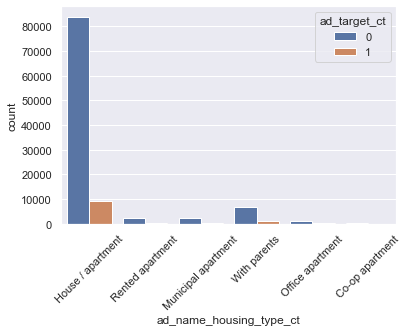

In [66]:
# Insight dataframe 2
insight_df_2 = df_application_data_2[["ad_sk_id_curr_ct", "ad_target_ct", "ad_name_housing_type_ct"]]
print("\nInsight dataframe - 2: Housing Type\n")
print(insight_df_2.head())
col = 'ad_name_housing_type_ct'
target_col = 'ad_target_ct'
sns.set()
s = sns.countplot(insight_df_2[col],hue=insight_df_2[target_col])
s.set_xticklabels(s.get_xticklabels(), rotation=45)


Insight dataframe - 3: Occupation Type

    ad_sk_id_curr_ct  ad_target_ct ad_occupation_type_ct
2             100004             0              Laborers
3             100006             0              Laborers
4             100007             0            Core staff
5             100008             0              Laborers
10            100014             0            Core staff


[Text(0, 0, 'Laborers'),
 Text(1, 0, 'Core staff'),
 Text(2, 0, 'Drivers'),
 Text(3, 0, 'Sales staff'),
 Text(4, 0, 'Private service staff'),
 Text(5, 0, 'Medicine staff'),
 Text(6, 0, 'Cooking staff'),
 Text(7, 0, 'Managers'),
 Text(8, 0, 'Waiters/barmen staff'),
 Text(9, 0, 'Low-skill Laborers'),
 Text(10, 0, 'High skill tech staff'),
 Text(11, 0, 'Security staff'),
 Text(12, 0, 'Cleaning staff'),
 Text(13, 0, 'Accountants'),
 Text(14, 0, 'Secretaries'),
 Text(15, 0, 'HR staff'),
 Text(16, 0, 'Realty agents'),
 Text(17, 0, 'IT staff')]

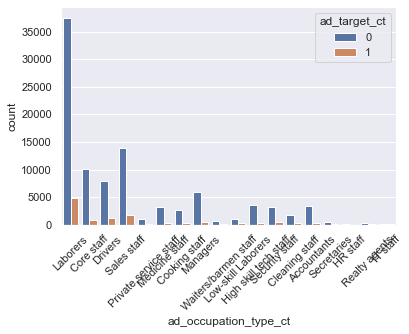

In [67]:
# Insight dataframe 3
insight_df_3 = df_application_data_2[["ad_sk_id_curr_ct", "ad_target_ct", "ad_occupation_type_ct"]]
print("\nInsight dataframe - 3: Occupation Type\n")
print(insight_df_3.head())
col = 'ad_occupation_type_ct'
target_col = 'ad_target_ct'
sns.set()
s = sns.countplot(insight_df_3[col],hue=insight_df_3[target_col])
s.set_xticklabels(s.get_xticklabels(), rotation=45)

**Encoding before machine learning**

In [68]:
merged_dataframe = encoder(merged_dataframe)

In [69]:
target_column = "ad_target_ct"
df1 = merged_dataframe.drop(target_column, 1)
df1 = df1.loc[:, ~df1.columns.str.contains('^Unnamed')]
feature_columns = list(df1)

X = merged_dataframe[feature_columns]
Y = merged_dataframe[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1) # 80% training and 20% test

**Binary classification**

In [70]:
# Decision Tree classifer
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Report - \n", classification_report(y_test,y_pred))

Report - 
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     20302
           1       0.62      0.66      0.64      2561

    accuracy                           0.92     22863
   macro avg       0.79      0.80      0.80     22863
weighted avg       0.92      0.92      0.92     22863



In [71]:
# Logisitic Regression
clf = LogisticRegression()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Report - \n", classification_report(y_test,y_pred))

Report - 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     20302
           1       0.00      0.00      0.00      2561

    accuracy                           0.89     22863
   macro avg       0.44      0.50      0.47     22863
weighted avg       0.79      0.89      0.84     22863



In [72]:
# Support Vector Machines
clf = svm.LinearSVC()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Report - \n", classification_report(y_test,y_pred))

Report - 
               precision    recall  f1-score   support

           0       0.96      0.00      0.00     20302
           1       0.11      1.00      0.20      2561

    accuracy                           0.11     22863
   macro avg       0.54      0.50      0.10     22863
weighted avg       0.87      0.11      0.03     22863



In [73]:
# Random Forest Classifier
clf = RandomForestClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Report - \n", classification_report(y_test,y_pred))

Report - 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     20302
           1       1.00      0.41      0.58      2561

    accuracy                           0.93     22863
   macro avg       0.97      0.71      0.77     22863
weighted avg       0.94      0.93      0.92     22863



In [74]:
# Neural Networks
clf = MLPClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Report - \n", classification_report(y_test,y_pred))

Report - 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     20302
           1       0.24      0.01      0.02      2561

    accuracy                           0.89     22863
   macro avg       0.56      0.50      0.48     22863
weighted avg       0.82      0.89      0.84     22863

